## 2023-12-07 Jonathan Meeting

Meeting for the first time in a month (Thanksgiving + Italy vaction). Meeting topic is focused on the model with interaction terms. Before break (11/20/2023) I sent an update confirming that the interaction terms do not improve model performance (e.g. my refactored code wasn't causing the issue). 

I will now do the follwing

1. Load in the experiment "2023_11_16_repeat_compare_prev_violation_stim_interactions.pkl"
2. Plot bits/trial (across & by animals)
3. Plot weights
4. Plot LL by model (train and test)
5. Plot LL by model, by animal (train and test) <-- want to confirm it goes down
6. Quantify LL by model, animal difference

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import sys
import pickle
[
    sys.path.append(str(folder))
    for folder in pathlib.Path("../../src/").iterdir()
    if folder.is_dir()
]

# from fitting_utils import create_violation_interaction_pairs
# from experiment_sigma_sweep import ExperimentSigmaSweep
# from multiclass_logistic_regression import MultiClassLogisticRegression
from model_visualizer import *


sns.set_context("talk")
%load_ext autoreload
%autoreload 2

## Load In

Loading in Experiment Class for the comparison experiment and initilizing a model visualzier object

In [3]:
file_path = "../../data/results/"
experiment_fname = "2023_11_16_repeat_compare_prev_violation_stim_interactions.pkl"

with open(file_path + experiment_fname, "rb") as f:
    experiment = pickle.load(f)

mvc = ModelVisualizerCompare(experiment)

## Bit / Trial Results

In [11]:
ORDER = [
    "psytrack_features",
    "filter_prev_violation",
    "filter_prev_violation_stim_itrx",
]

mvc = ModelVisualizerCompare(experiment)
df = mvc.find_best_fit(group="model_name")
df["model_name"] = pd.Categorical(df["model_name"], categories=ORDER, ordered=True)

# Sort the DataFrame
df = df.sort_values("model_name")

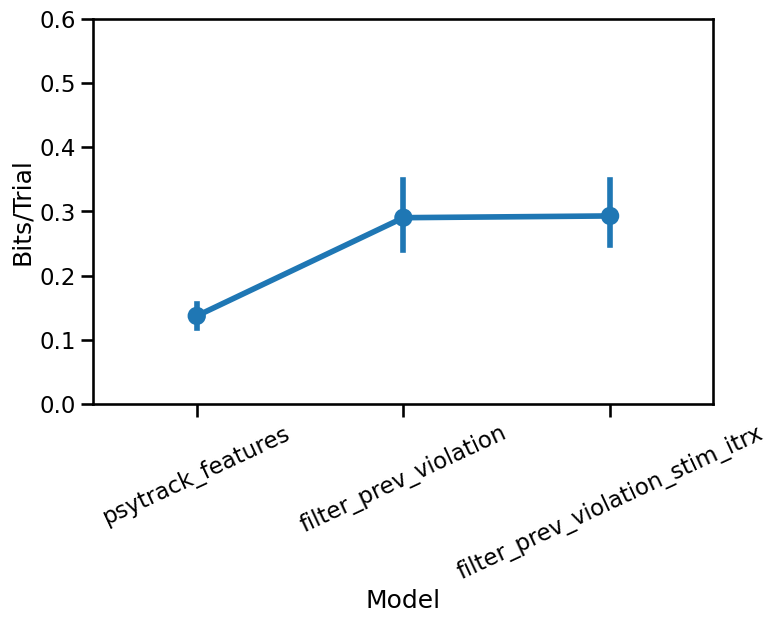

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
mvc.plot_model_comparison(
    hue=None,
    ax=ax,
    order=ORDER,
    ylim=(0, 0.6),
)

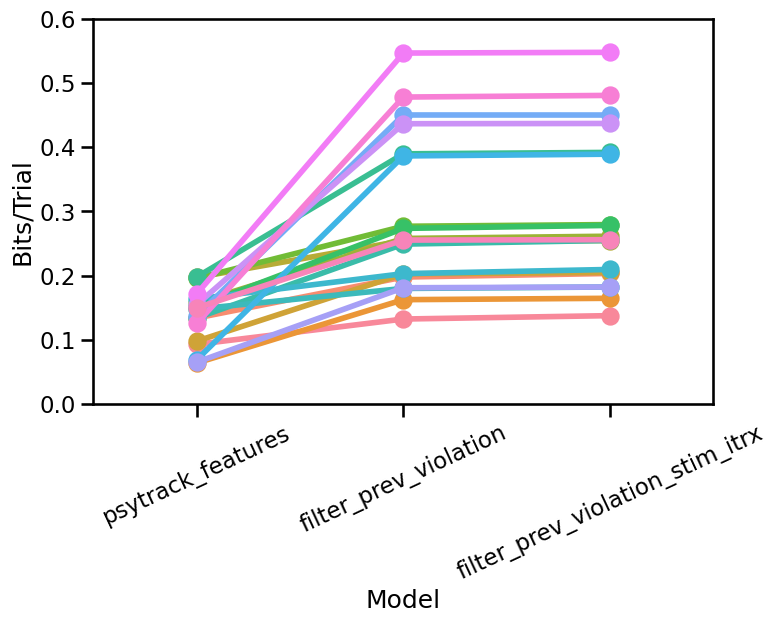

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
mvc.plot_model_comparison(
    hue="animal_id",
    ax=ax,
    order=ORDER,
    ylim=(0, 0.6),
)

## Train/Test LL

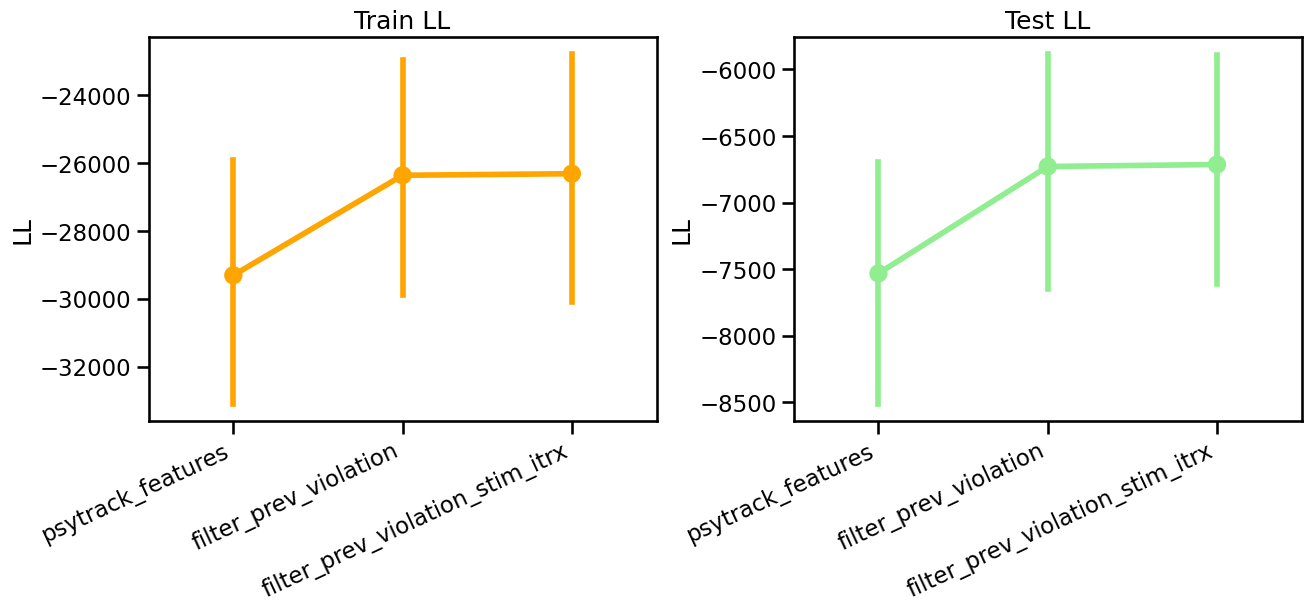

In [18]:
mvc.plot_train_and_test_ll(
    order=ORDER,
)

In [44]:
results_df = mvc.fit_models.query("model_name != 'psytrack_features'").copy()
results_df["model_name"] = results_df["model_name"].cat.remove_unused_categories()
results_df["train_ll"] = results_df.train_nll * -1
results_df["test_ll"] = results_df.nll * -1

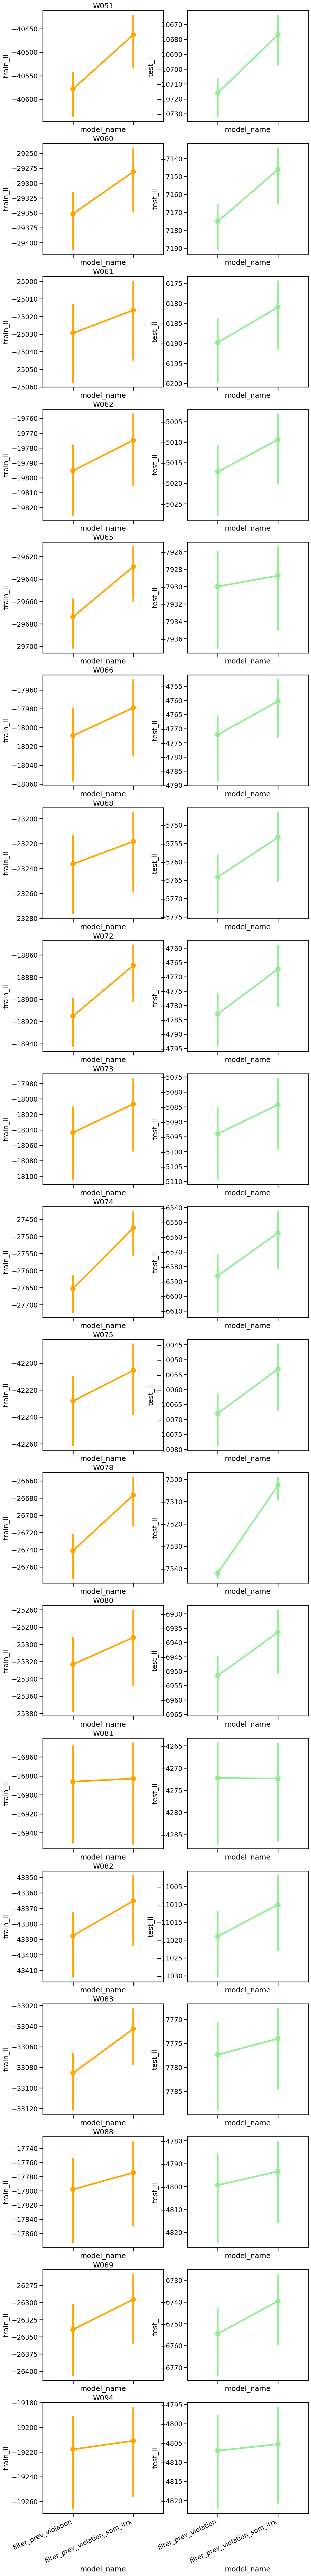

In [52]:
n_animals = mvc.experiment.n_animals

fig, ax = plt.subplots(n_animals, 2, figsize=(12, 6 * n_animals), sharex=True)

for ii, (animal_id, animal_df) in enumerate(results_df.groupby("animal_id")):
    sns.pointplot(
        data=animal_df, x="model_name", y="train_ll", ax=ax[ii, 0], color="orange"
    )
    sns.pointplot(
        data=animal_df, x="model_name", y="test_ll", ax=ax[ii, 1], color="lightgreen"
    )
    ax[ii, 0].set_title(animal_id)
    # move the legned outside the plot
    # ax[ii].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

for i in range(2):
    _ = ax[n_animals - 1, i].set_xticklabels(
        ax[n_animals - 1, i].get_xticklabels(), rotation=25, ha="right"
    )

> The train & test LL go UP for all animals, just by a small amount.

Next plot: for the best fit model for each animal, plot (interactions ll - filter only ll) barplot 

In [100]:
def make_pivot_for_model_ll_comp(mvc, mode):
    """
    mvc: model visualizer
    mode: train or test
    """

    # get the best fit df, drop the fits for psytrack features and make
    # pandas forget about the category
    best_test_df = mvc.find_best_fit(group="model_name", mode=mode)
    best_test_df = best_test_df.query("model_name !='psytrack_features'").copy()
    best_test_df["model_name"] = best_test_df.model_name.cat.remove_unused_categories()

    # convert from nll -> ll
    if mode == "test":
        nll = "nll"
    elif mode == "train":
        nll = "train_nll"
    best_test_df[f"{mode}_ll"] = best_test_df[nll] * -1

    # make pivot with difference btetween filter prv viol itrx and filter prev viol
    pivot_df = best_test_df.pivot(
        index="animal_id", columns="model_name", values=f"{mode}_ll"
    )
    pivot_df[f"{mode}_ll_difference"] = (
        pivot_df["filter_prev_violation_stim_itrx"] - pivot_df["filter_prev_violation"]
    )
    pivot_df.reset_index(inplace=True)

    return pivot_df

In [101]:
test_ll_data = make_pivot_for_model_ll_comp(mvc, mode="test")
train_ll_data = make_pivot_for_model_ll_comp(mvc, mode="train")

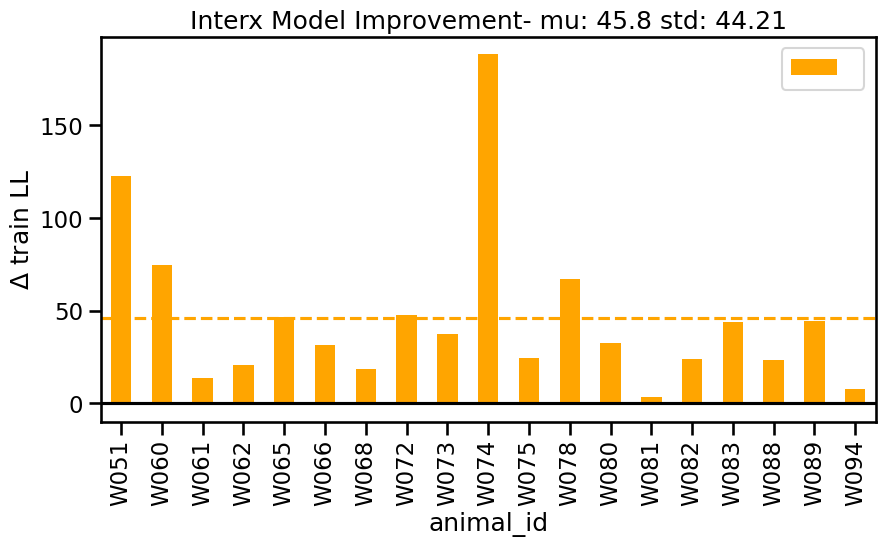

In [113]:
fig, ax = plt.subplots(figsize=(10, 5))
MODE = "train"
if MODE == "train":
    color = "orange"
else:
    color = "lightgreen"
data = make_pivot_for_model_ll_comp(mvc, mode=MODE)
data.plot(
    kind="bar",
    x="animal_id",
    y=f"{MODE}_ll_difference",
    ax=ax,
    label="",
    color=color,
)

mean = data[f"{MODE}_ll_difference"].mean().round(2)
std = data[f"{MODE}_ll_difference"].std().round(2)
ax.axhline(y=0, color="k")
ax.axhline(y=mean, color=color, linestyle="--")
_ = ax.set(
    ylim=(-10, None),
    ylabel=f"$\Delta$ {MODE} LL",
    title=f"Interx Model Improvement- mu: {mean} std: {std}",
)

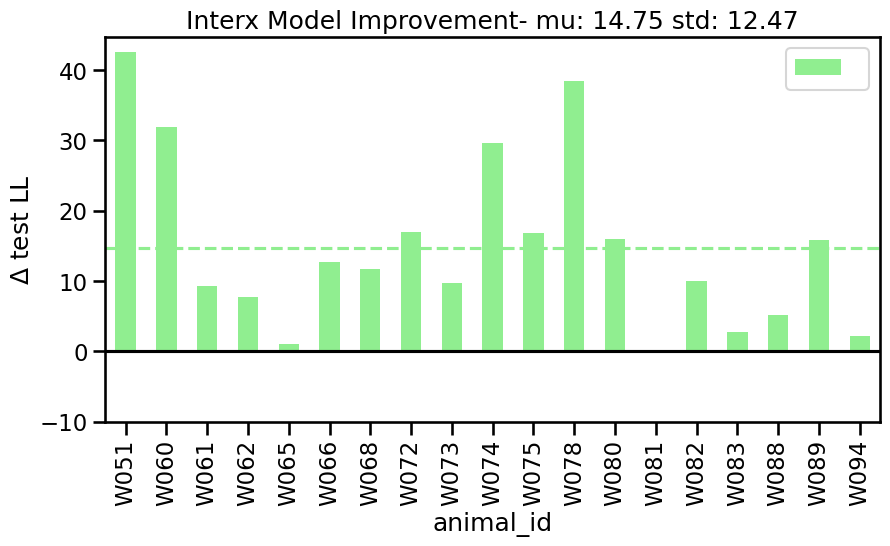

In [114]:
fig, ax = plt.subplots(figsize=(10, 5))
MODE = "test"
if MODE == "train":
    color = "orange"
else:
    color = "lightgreen"
data = make_pivot_for_model_ll_comp(mvc, mode=MODE)
data.plot(
    kind="bar",
    x="animal_id",
    y=f"{MODE}_ll_difference",
    ax=ax,
    label="",
    color=color,
)

mean = data[f"{MODE}_ll_difference"].mean().round(2)
std = data[f"{MODE}_ll_difference"].std().round(2)
ax.axhline(y=0, color="k")
ax.axhline(y=mean, color=color, linestyle="--")
_ = ax.set(
    ylim=(-10, None),
    ylabel=f"$\Delta$ {MODE} LL",
    title=f"Interx Model Improvement- mu: {mean} std: {std}",
)